<a href="https://colab.research.google.com/github/BaberFaisal/Churn_Modelling_Using_Decision_Tree/blob/main/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [5]:
file = pd.read_csv("/content/Churn_Modelling.csv")

In [7]:
file.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [8]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


I'll begin by checking the balance of the classes in target variable (Exited), as this will help to determine how to prepare our data. I

In [10]:
file["Exited"].value_counts()

,count
Exited,
0,7963
1,2037


The class of  target variable is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme.Will preserve this ratio when we model.

In [15]:
avg_churned_bal = file[file["Exited"]==1]["Balance"].mean()

In [16]:
avg_churned_bal

91108.53933726068

This shows that the customers who churned each took with them €91,108.54, on average. That's a lot of money! This represents the average cost of the model predicting a false negative.

I begin by dropping the columns that wouldn't expect to offer any predictive signal to the model. These columns include RowNumber, CustomerID, and Surname. will drop these columns so they don't introduce noise to our model.

I'll also drop the Gender column, because don't want model to make predictions based on gender.

In [17]:
churn_df = file.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis=1)

In [19]:
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


**Feature transformation**

Next, I'll dummy encode the Geography variable, which is categorical. There are three possible categories captured here: France, Spain, and Germany. When I call pd.get_dummies() on this feature, it will replace the Geography column with three new Boolean columns--one for each possible category contained in the column being dummied.

When I specify drop_first='True' in the function call, it means that instead of replacing Geography with three new columns, it will instead replace it with two columns. I can do this because no information is lost from this, but the dataset is shorter and simpler.

In this case, I end up with two new columns called Geography_Germany and Geography_Spain. I don't need a Geography_France column. Why not? Because if a customer's values in Geography_Germany and Geography_Spain are both 0, we'll know they're from France!

In [23]:
# Dummy encode categorical variables
churn_df = pd.get_dummies(churn_df, drop_first=True)

In [27]:
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True


In [24]:
# Define the y (target) variable
y = churn_df["Exited"]
X = churn_df.copy()
# Define the X (predictor) variables
X = X.drop("Exited", axis=1)


# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, stratify=y,
                                                    random_state=42)

In [25]:
#instantiate the model
decision_tree = DecisionTreeClassifier(random_state=42)

#fit the model to trainning data
decision_tree.fit(X_train,y_train)

# Make predictions on test dat(a
y_pred = decision_tree.predict(X_test)


In [29]:
#Performan metrics
print("Accuracy:","%.3f" %accuracy_score(y_test,y_pred))
print("Precision:","%.3f" %precision_score(y_test,y_pred))
print("Recall:","%.3f" %recall_score(y_test,y_pred))
print("F1 Score:","%.3f" %f1_score(y_test,y_pred))



Accuracy: 0.796
Precision: 0.499
Recall: 0.505
F1 Score: 0.502


**Confusion matrix**

Let's inspect the confusion matrix of decision tree's predictions. First, I'll write a short helper function to display the matrix.

In [30]:
def conf_matrix_plot(model, x_data, y_data):

    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)

    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

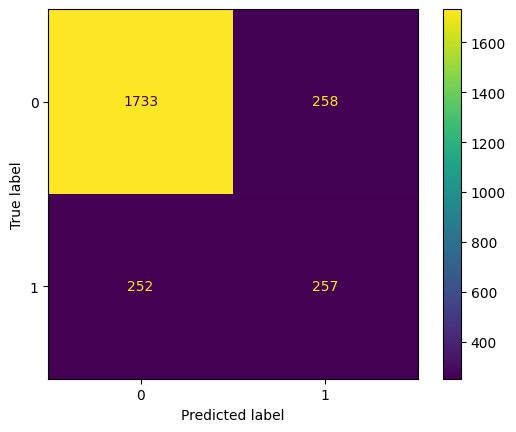

In [31]:
conf_matrix_plot(decision_tree, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other.

**Decision Tree**

Note that if I did not set max_depth=2, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. We're most interested in the splits nearest the root, because these tell us the most predictive features.

class_names displays what the majority class of each node is, and filled colors the nodes according to their majority class.

Note that this plot represents how the tree grew from the training data. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

In [33]:
X.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain'],
      dtype='object')

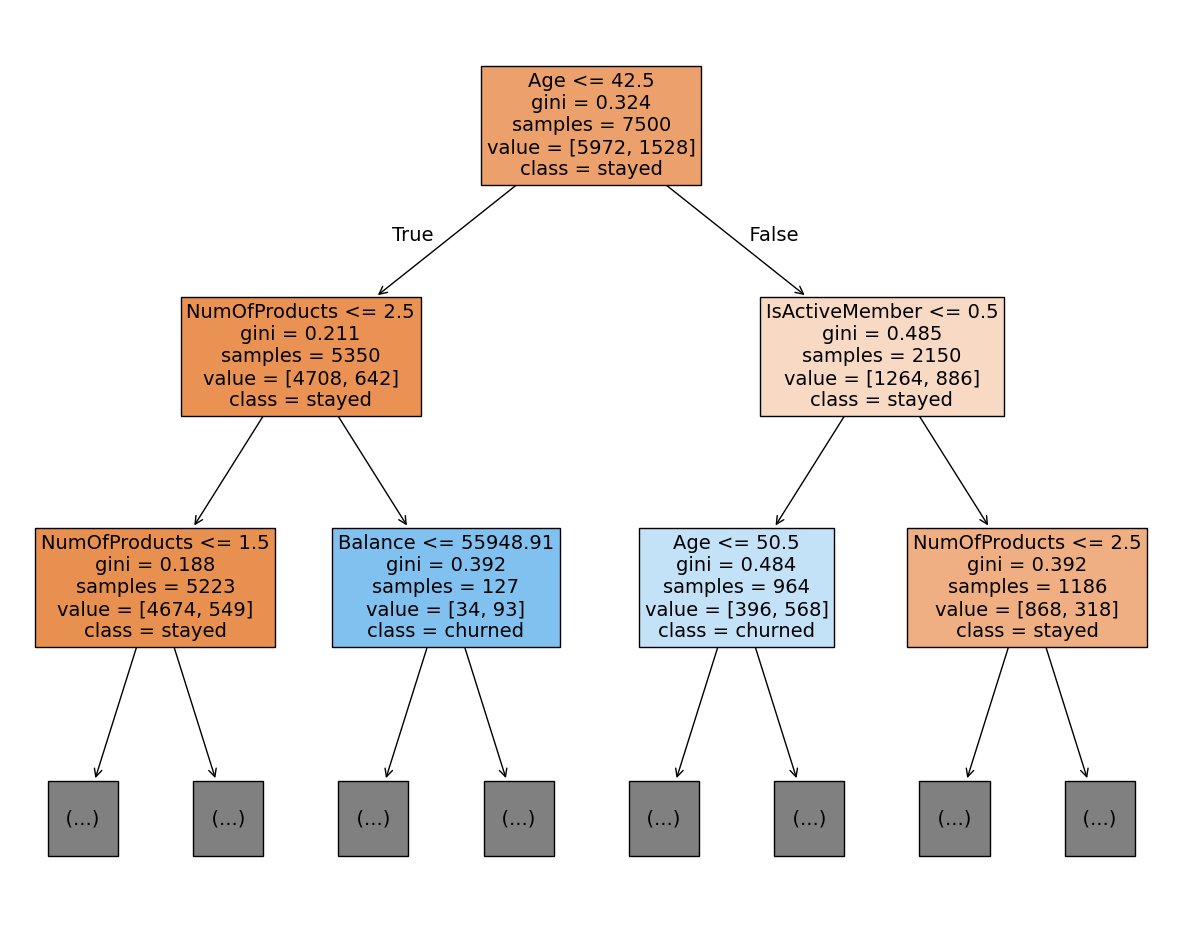

In [41]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'churned'}, filled=True);
plt.show()

The first line of information in each node is the feature and split point that the model identified as being most predictive. In other words, this is the question that is being asked at that split. For our root node, the question was: Is the customer less than or equal to 42.5 years old?

At each node, if the answer to the question it asks is "yes," the sample would move to the child node on the left. If the answer is "no," the sample would go to the child node on the right.

gini refers to the node's Gini impurity. This is a way of measuring how "pure" a node is. The value can range from 0 to 0.5. A Gini score of 0 means there is no impurity—the node is a leaf, and all of its samples are of a single class. A score of 0.5 means the classes are all equally represented in that node.

samples is simply how many samples are in that node, and value indicates how many of each class are in the node. Returning to the root node, we have value = [5972, 1528]. Notice that these numbers sum to 7,500, which is the number of samples in the node. This tells us that 5,972 customers in this node stayed (y=0) and 1,528 customers churned (y=1).

Lastly, we have class. This tells us the majority class of the samples in each node.


This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn.